In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import random as rng
%matplotlib inline

rng.seed(12345)

In [7]:
# path
attribution_root = Path('/cluster/scratch/jingyli/interpretable/attribution_result/')
figure_log_root = Path('/cluster/scratch/jingyli/interpretable/data_intermediate/visualization')

In [3]:
# functions to read attribution and format attribution matrix
def read_attr(DATE, TIME, CHANNEL, W, MODEL):
    file_path = f"{DATE}_berlin_9ch{TIME}-saliency-target-channel{CHANNEL}-W{W}.npy"
    figure_log_path = figure_log_root / f"{MODEL}/figures" / f"{DATE}_{TIME}" / "watershed" / f"W{W}"
    if not os.path.exists(figure_log_root):
        os.makedirs(figure_log_root)
    log_root = attribution_root / f"{MODEL}" / f"{DATE}_{TIME}"
    attr = np.load(os.path.join(log_root, file_path))[0]
    return attr, figure_log_path


def get_space_mat(attr):
    # Get contribution per timeepoch
    C, H, W = attr.shape
    time_attr = np.sum(attr[:108].reshape(12, -1, H, W)[:, :-1, ...].reshape(12, -1, H, W), axis=1)
    # Get contribution for static features
    static_attr = attr[108:]
    # Stack dynamic + static
    stacked_attr = np.concatenate((time_attr, static_attr), axis=0)
    
    return stacked_attr

In [4]:
def normalize_space_mat(space_mat):
    """
        Normalize each dim into [0,255] (unit8)
        
    """
    mins = np.amin(space_mat, axis=(1,2))[:, np.newaxis, np.newaxis]
    maxs = np.amax(space_mat, axis=(1,2))[:, np.newaxis, np.newaxis]

    space_mat_ = (space_mat - mins)/(maxs - mins)*255

    # Round to integer
    space_mat_ = np.round(space_mat_, 0).astype('uint8')

    # Change the axis sequence to  [H,W,C]
    space_mat_ = np.moveaxis(space_mat_, (0,1,2), (2,0,1))
    
    return space_mat_

def plot_attr_map(attr_dim, ax):
    """
        Plot attribution map of a dimension
    """
    im = ax.imshow(attr_dim, cmap='RdBu_r', vmin=0, vmax=255)
    ax.set_title("attribution map")
    
    

def plot_attribution_hist(attr_arr):
    """
        Plot histogram of a list of attribution levels
    """
    plt.hist(space_mat_[...,0].ravel(), bins=100)
    plt.yscale('log')
    plt.show()
    

def log_scale(arr):
    """
        Make the 2D array to log scale; Normalize it into [0,255]
    """
    arr_ = np.log1p(arr)
    # Normalize
    arr_ = (arr_ - np.min(arr_))/(np.max(arr_) - np.min(arr_))*255
    arr_ = np.round(arr_, 0).astype("uint8")
    return arr_


def watershed(t, binary_thred=5, dist_peak_thred=0.5, visualize_inter=False, visualize_final=True):
    """
        Run watershed algorithm over t
        @binary_thred: int [0,255]
        @dist_peak_thred: float [0.,1.]
        return: markers learned after watershed
    """
    # Create binary image from source image
    _, bw = cv.threshold(t.astype("uint8"), binary_thred, 255, cv.THRESH_BINARY)
    bw = bw.astype("uint8")
    
    # Perform the distance transform algorithm
    dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
    # Normalize the distance image for range = {0.0, 1.0}
    # so we can visualize and threshold it
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    # Visualize distance transform image
    if visualize_inter:
        plt.imshow(dist, cmap='gray')
        
    # Threshold to obtain the peaks
    # This will be the markers for the foreground objects
    _, dist = cv.threshold(dist, dist_peak_thred, 1.0, cv.THRESH_BINARY)
    # Dilate a bit the dist image
    kernel1 = np.ones((3,3), dtype=np.uint8)
    dist = cv.dilate(dist, kernel1)
    # Visualize peaks in distance tranform
    if visualize_inter:
        plt.imshow(dist, cmap='gray')
    
    # Create the CV_8U version of the distance image
    # It is needed for findContours()
    dist_8u = dist.astype('uint8')
    # Find total markers
    contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Create the marker image for the watershed algorithm
    markers = np.zeros(dist.shape, dtype=np.int32)
    
    # Draw the foreground markers
    for i in range(len(contours)):
        cv.drawContours(markers, contours, i, (i+1), -1)
    # Draw the background marker
    cv.circle(markers, (5,5), 3, (255,255,255), -1)
    markers_8u = (markers * 10).astype('uint8')
    
    # Perform the watershed algorithm
    cv.watershed(np.repeat(t, repeats=3, axis=2), markers)

    mark = markers.astype('uint8')
    mark = cv.bitwise_not(mark)
    
    if visualize_final:
        # Generate random colors
        colors = []
        for contour in contours:
            colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
        # Create the result image
        dst = np.ones((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)*255
        # Fill labeled objects with random colors
        for i in range(markers.shape[0]):
            for j in range(markers.shape[1]):
                index = markers[i,j]
                if index > 0 and index <= len(contours):
                    dst[i,j,:] = colors[index-1]
        # Visualize the final image
        plt.imshow(dst)
        plt.title(f"Watershed segmentations: {len(contours)}")
        
    return markers, contours


def plot_attr_over_watershed(attr, markers, contours, ax):
    """
        Plot attribution map over watershed segmentation
    """
    # Generate random colors
    colors = []
    for contour in contours:
        colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
    # Create the result image
    dst = np.ones((markers.shape[0], markers.shape[1], 4), dtype=np.uint8)*255
    # Fill labeled objects with random colors
    for i in range(markers.shape[0]):
        for j in range(markers.shape[1]):
            index = markers[i,j]
            if index > 0 and index <= len(contours):
                dst[i,j,:3] = colors[index-1]
    # Alpha denotes the attribution level
    dst[...,-1] = log_scale(np.squeeze(attr, axis=-1))
    ax.imshow(dst)
    ax.set_title(f"Watershed segmentations: {len(contours)}")

# Explore spatial dependency captured by UNet

We used watershed algorithm over attribution maps, then we can segment the study area into different subgraphs


## 1. Read Attribution

In [8]:
MODEL = "resUnet"
DATE = "2019-07-01"
TIME = 144
CHANNEL = 0
W = f"{12}_{12}"

attr, figure_log_path = read_attr(DATE, TIME, CHANNEL, W, MODEL)

space_mat = get_space_mat(attr) 
# of shape [19,512,448]
# 19 = 12 timeepochs + 7 static features

## 2. Watershed for attribution

Normalization of attribution values to [0,255] and make it as integer

WATERSHED: detected 9


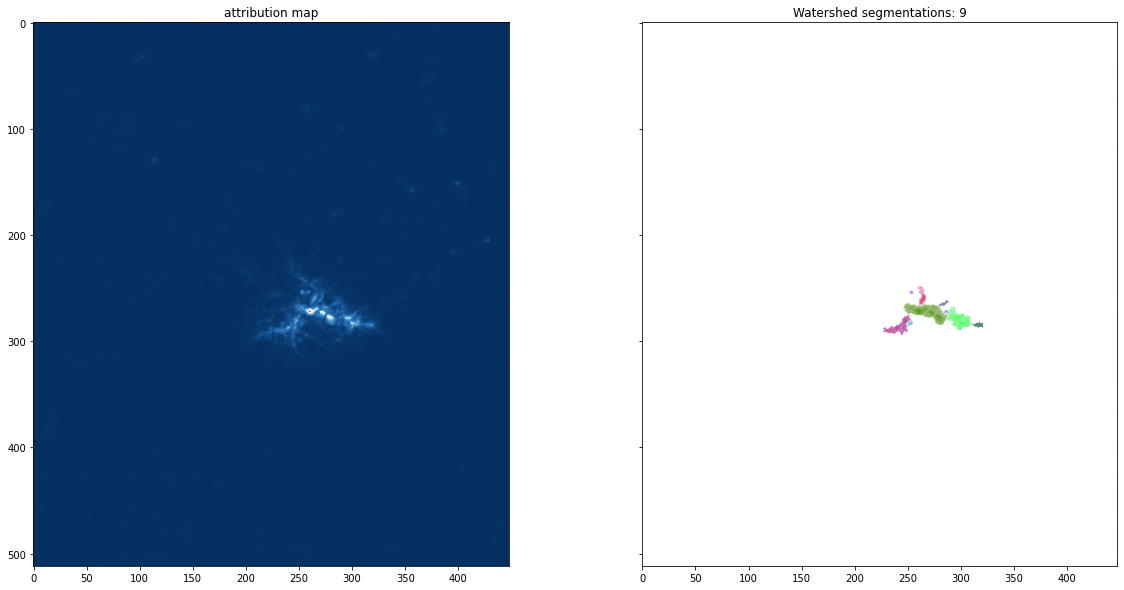

In [16]:
space_mat_ = normalize_space_mat(space_mat) # of shape [512,448,19]

# Dimension for watershed
n = 11
select_dim_attr = space_mat_[:,:,n:n+1]

##### Watershed

# Parameters
BINARY_THRED=20
DIST_PEAK_THRED=0.25

mark, contours = watershed(select_dim_attr, binary_thred=BINARY_THRED, dist_peak_thred=DIST_PEAK_THRED, visualize_final=False)
print(f"WATERSHED: detected {len(contours)}")

np.save("test_watershed", 
        np.concatenate((mark[...,np.newaxis], select_dim_attr), axis=-1))

# Visualize
fig, axes = plt.subplots(1,2, figsize=(20,10), sharey=True)
plot_attr_map(select_dim_attr, axes[0])
plot_attr_over_watershed(select_dim_attr, mark, contours, axes[1])
plt.savefig('test_Watershed.png', bbox_inches='tight')